In [1]:
import pandas as pd
import numpy as np
from surprise import SVDpp, Dataset, Reader, accuracy                  
from surprise.model_selection import train_test_split, GridSearchCV    
import matplotlib.pyplot as plt     

In [2]:
ratings = pd.read_csv("ratings_small.csv")
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')


In [3]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

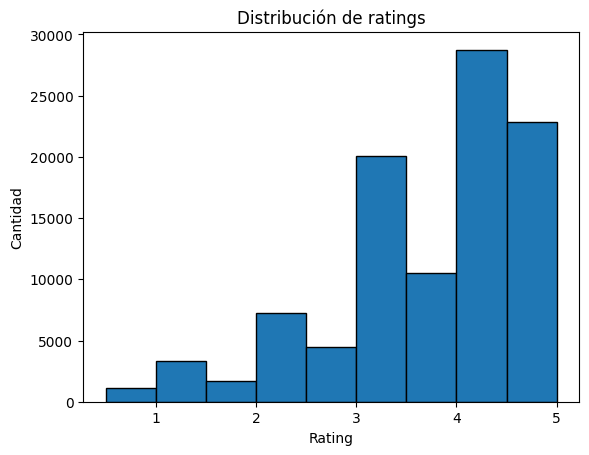

In [4]:
plt.figure()
plt.hist(ratings['rating'], bins=np.arange(0.5, 5.5, 0.5), edgecolor='black')
plt.xlabel("Rating")
plt.ylabel("Cantidad")
plt.title("Distribución de ratings")
plt.show()

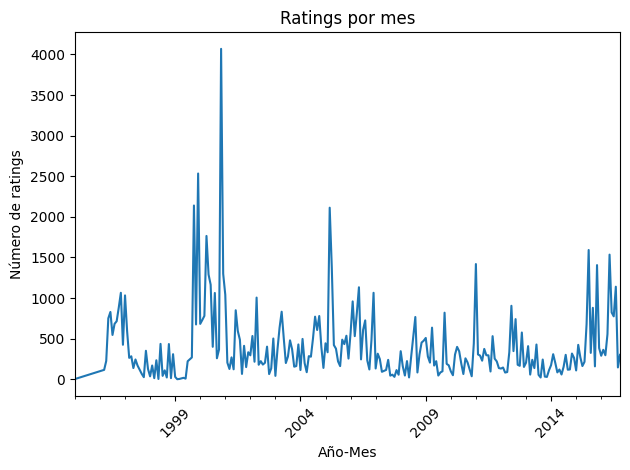

In [5]:
ratings['year_month'] = ratings['timestamp'].dt.to_period('M')
monthly_counts = ratings.groupby('year_month').size()

plt.figure()
monthly_counts.plot(kind='line')
plt.xlabel("Año-Mes")
plt.ylabel("Número de ratings")
plt.title("Ratings por mes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

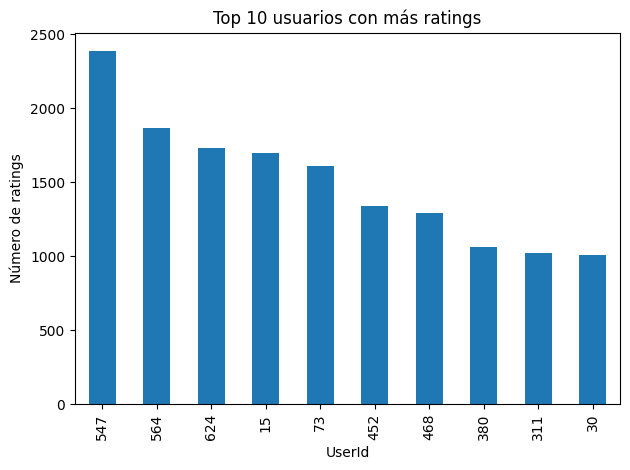

In [6]:
user_counts = ratings['userId'].value_counts().sort_values(ascending=False).head(10)
plt.figure()
user_counts.plot(kind='bar')
plt.xlabel("UserId")
plt.ylabel("Número de ratings")
plt.title("Top 10 usuarios con más ratings")
plt.tight_layout()
plt.show()

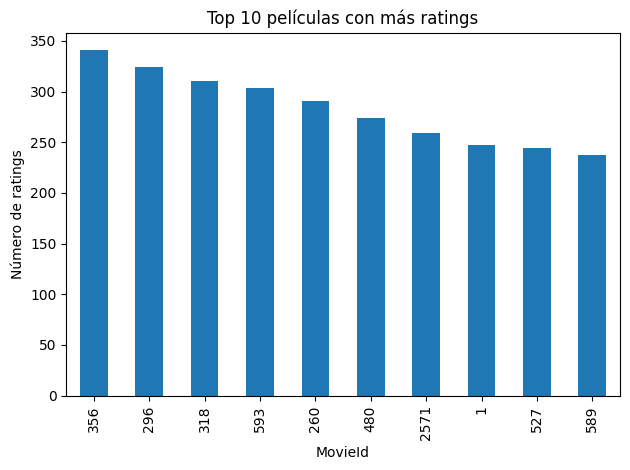

In [7]:
movie_counts = ratings['movieId'].value_counts().sort_values(ascending=False).head(10)
plt.figure()
movie_counts.plot(kind='bar')
plt.xlabel("MovieId")
plt.ylabel("Número de ratings")
plt.title("Top 10 películas con más ratings")
plt.tight_layout()
plt.show()

In [8]:
movie_counts = ratings["movieId"].value_counts()                         
print("Número de valoraciones por película :")            
print(movie_counts, "\n")                                         

min_movie_ratings = 40                                                    

valid_movies = movie_counts[movie_counts >= min_movie_ratings].index     
ratings = ratings[ratings["movieId"].isin(valid_movies)].copy()          

print(f"Películas totales antes de filtrar: {len(movie_counts)}")          
print(f"Películas tras filtrar (<{min_movie_ratings} ratings): {len(valid_movies)}\n") 

user_counts = ratings["userId"].value_counts()                            
min_user_ratings = 10                                                     
valid_users = user_counts[user_counts >= min_user_ratings].index           
ratings = ratings[ratings["userId"].isin(valid_users)].copy()        

Número de valoraciones por película :
movieId
356       341
296       324
318       311
593       304
260       291
         ... 
98604       1
103659      1
104419      1
115927      1
6425        1
Name: count, Length: 9066, dtype: int64 

Películas totales antes de filtrar: 9066
Películas tras filtrar (<40 ratings): 616



In [9]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [10]:
param_grid = {
    "n_factors": [50, 100],       
    "n_epochs": [10, 20],         
    "lr_all": [0.005, 0.01],      
    "reg_all": [0.02, 0.05]       
}

gs = GridSearchCV(
    SVDpp,
    param_grid,
    measures=["rmse"],
    cv=2,            
    n_jobs=-1
)
gs.fit(data)
best_params = gs.best_params["rmse"]
print("Mejores parámetros (búsqueda reducida):", best_params)

Mejores parámetros (búsqueda reducida): {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.05}


In [11]:
best_algo = SVDpp(
    n_factors=best_params["n_factors"],
    n_epochs=best_params["n_epochs"],
    lr_all=best_params["lr_all"],
    reg_all=best_params["reg_all"],
    random_state=42
)
best_algo.fit(trainset)                                                      

predictions = best_algo.test(testset)                                             
rmse = accuracy.rmse(predictions, verbose=False)                             
print(f"RMSE final en test (SVD++): {rmse:.4f}")                            


RMSE final en test (SVD++): 0.8308


In [15]:
user_id = 661
seen = set(ratings.loc[ratings["userId"] == user_id,       
                      "movieId"])                          

all_items = ratings["movieId"].unique()                   
candidates = [iid for iid in all_items if iid not in seen] 

preds_user = [best_algo.predict(user_id, iid)             
              for iid in candidates]                       
top25 = sorted(preds_user, key=lambda x: x.est, reverse=True)[:25] 

df_recs = pd.DataFrame(                                     
    [(p.iid, p.est) for p in top25],                        
    columns=["movieId", "predicted_rating"]                 
)                                                           

print(f"\nTop-10 recomendaciones SVD++ para user_id = {user_id}:")  
print(df_recs)   


Top-10 recomendaciones SVD++ para user_id = 661:
    movieId  predicted_rating
0      4993          4.840766
1      2542          4.654047
2      5618          4.649701
3       969          4.625563
4       608          4.604177
5      1196          4.597693
6       913          4.595189
7      1276          4.592923
8       858          4.588296
9      2064          4.585989
10    58559          4.569745
11      908          4.557965
12     1203          4.548987
13       50          4.548900
14     4011          4.545216
15     1221          4.544187
16     2959          4.537570
17     6016          4.533827
18     1233          4.531406
19     1207          4.529287
20    78499          4.526925
21     1204          4.525415
22      260          4.513164
23     1293          4.500266
24     1198          4.492478


In [17]:
movie_list = list(df_recs ['movieId'] )

In [19]:
import random
random.shuffle(movie_list)
movie_list

[608,
 858,
 1207,
 1204,
 908,
 1233,
 50,
 913,
 1196,
 1221,
 78499,
 2064,
 1293,
 1276,
 260,
 4993,
 4011,
 5618,
 2959,
 1203,
 2542,
 6016,
 1198,
 58559,
 969]

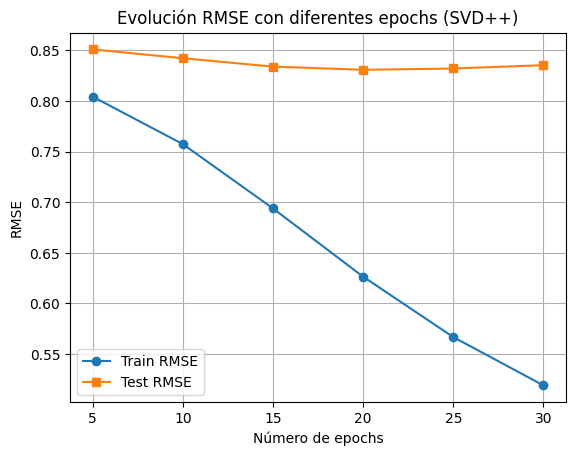

In [20]:
train_losses, test_losses = [], []
epochs_range = range(5, 35, 5)
for ne in epochs_range:                                                       
    temp_algo = SVDpp(
    n_factors=best_params['n_factors'],
    n_epochs=ne,
    lr_all=best_params['lr_all'],
    reg_all=best_params['reg_all'],
    random_state=42
    )                                                                   
    temp_algo.fit(trainset)                                                  
    train_pred = temp_algo.test(trainset.build_testset())                     
    test_pred  = temp_algo.test(testset)                                       
    train_losses.append(accuracy.rmse(train_pred, verbose=False))              
    test_losses.append(accuracy.rmse(test_pred, verbose=False))                

plt.figure()                                                                  
plt.plot(epochs_range, train_losses, marker="o", label="Train RMSE")         
plt.plot(epochs_range, test_losses,  marker="s", label="Test RMSE")          
plt.xlabel("Número de epochs")                                                
plt.ylabel("RMSE")                                                           
plt.title("Evolución RMSE con diferentes epochs (SVD++)")                       
plt.legend()                                                                 
plt.grid(True)                                                               
plt.show()    